# Visual Sentiment analysis with CNN

In [1]:
from pathlib import Path
import time

import warnings
from typing import Any, Dict, Tuple

from PIL import Image

import pandas as pd
import numpy as np

from tqdm import tqdm

import matplotlib.pyplot as plt

import torch
from torch import optim
from torchvision import transforms, models
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset

from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings("ignore")
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

In [2]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(device)

cuda


## Data downloading and preprocessing

In [3]:
NUM_CLASSES = 3

BATCH_SIZE = 32
NUM_EPOCHS = 10

BASE_DIR = Path("..")

In [4]:
image_info_df = pd.read_csv("../image_sentiment_data.csv")
image_info_df.head()

,image_path,sentiment
0,data/preprocess_images/positive/104505632.jpg,positive
1,data/preprocess_images/positive/1059249846.jpg,positive
2,data/preprocess_images/positive/108501238.jpg,positive
3,data/preprocess_images/positive/1089046474.jpg,positive
4,data/preprocess_images/positive/1096822187.jpg,positive


In [5]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(image_info_df["sentiment"])

In [6]:
def prepare_dataloaders(
    image_data_info: pd.DataFrame,
    image_size: Tuple[int, int],
    test_size: float,
    labels: np.ndarray,
    device: str,
    shuffle_train: bool = True,
    shuffle_test: bool = True,
    batch_size_train: int = 32,
    batch_size_test: int = 1,
) -> Tuple[DataLoader, DataLoader]:
    images = []
    image_paths = image_data_info["image_path"].tolist()

    image_transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

    for image_path in tqdm(image_paths):
        image_path_ = Path(BASE_DIR / image_path).as_posix()
        image = Image.open(image_path_)
        images.append(image_transform(image).numpy())

    images = np.array(images)

    X = torch.from_numpy(images)
    y = np.array(labels).astype(np.int64)
    y = F.one_hot(torch.from_numpy(y).to(torch.int64)).to(torch.float64)

    train_size = 1 - test_size
    X_train = X[: int(train_size * len(X))]
    y_train = y[: int(train_size * len(y))]
    X_test = X[int(train_size * len(X)):]
    y_test = y[int(train_size * len(y)):]

    train_dataset = TensorDataset(X_train.to(device), y_train.to(device))
    test_dataset = TensorDataset(X_test.to(device), y_test.to(device))

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=shuffle_train)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size_test, shuffle=shuffle_test)
    return train_dataloader, test_dataloader


In [7]:
def f1_weighted_score(preds: torch.Tensor, labels: torch.Tensor):
    pred_numpy = preds.cpu().detach().numpy()
    labels_numpy = labels.cpu().detach().numpy()
    pred_flatten = np.argmax(pred_numpy, axis=1).flatten()
    labels_flatten = np.argmax(labels_numpy, axis=1).flatten()
    return f1_score(labels_flatten.astype(np.int32), pred_flatten.astype(np.int32), average="weighted")

In [8]:
def train(
    model: torch.nn.Module,
    dataloader: DataLoader,
    optim: optim.Optimizer,
    loss_func: torch.nn.Module,
) -> Tuple[float, float]:
    loss = 0
    accuracy = 0
    model.train()
    for image, sentiment in dataloader:
        optim.zero_grad()
        preds = model(image).squeeze()
        loss_current = loss_func(preds, sentiment)
        accuracy_curr = f1_weighted_score(preds, sentiment)
        loss_current.backward()
        optim.step()
        loss += loss_current.item()
        accuracy += accuracy_curr.item()
    return loss / len(dataloader), accuracy / len(dataloader)

In [9]:
def validate(
    model: torch.nn.Module,
    dataloader: DataLoader,
    loss_func: torch.nn.Module,
) -> Tuple[float, float]:
    loss = 0
    accuracy = 0
    model.eval()
    with torch.no_grad():
        for image, sentiment in dataloader:
            preds = model(image).squeeze()
            loss_current = loss_func(preds, sentiment)
            accuracy_current = f1_weighted_score(preds, sentiment)
            loss += loss_current.item()
            accuracy += accuracy_current.item()
    return loss / len(dataloader), accuracy / len(dataloader)

In [10]:
def training(
    model: torch.nn.Module,
    train_data: DataLoader,
    validate_data: DataLoader,
    optim: optim.Optimizer,
    loss_func: torch.nn.Module,
    num_epochs: int = 10,
) -> Dict[str, Any]:
    best_loss = float('inf')
    history = {
        "train": {
            "loss": [],
            "accuracy": [],
        },
        "valid": {
            "loss": [],
            "accuracy": [],
        }
    }
    for epoch in range(num_epochs):
        print(f"{'=' * 15} Epoch: {epoch + 1} {'=' * 15}")
        time_start = time.time()
        train_loss, train_accuracy = train(model, train_data, optim, loss_func)
        print(f"Train: loss={train_loss:.3f}, accuracy={train_accuracy:.3f}")
        validation_loss, validation_accuracy = validate(model, validate_data, loss_func)
        print(f"Validation: loss={validation_loss:.3f}, accuracy={validation_accuracy:.3f}")
        time_end = time.time()
        time_delta = time_end - time_start
        if validation_loss < best_loss:
            best_loss = validation_loss
        history["train"]["accuracy"].append(train_accuracy)
        history["train"]["loss"].append(train_accuracy)
        history["valid"]["accuracy"].append(validation_accuracy)
        history["valid"]["loss"].append(validation_loss)
        print(f"Time elapsed: {time_delta:.2f} s\n{'=' * 40}")
    return history

In [11]:
def plot_history(history: dict) -> None:
    train = history.get("train")
    valid = history.get("valid")
    plt.title("Loss")
    plt.plot(train.get("loss"), label="train")
    plt.plot(valid.get("loss"), label="valid")
    plt.legend()
    plt.show()
    plt.title("Accuracy")
    plt.plot(train.get("accuracy"), label="train")
    plt.plot(valid.get("accuracy"), label="valid")
    plt.legend()
    plt.show()

## Model validation

In [12]:
def set_parameter_requires_grad(model: torch.nn.Module, feature_extracting: bool):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [13]:
def init_model(
    model_name: str,
    num_classes: int,
    feature_extract: bool,
    use_pretrained: bool = True
) -> Tuple[torch.nn.Module, int]:
    model = None
    input_size = 0
    if model_name == "resnet":
        model = models.resnet50(pretrained=use_pretrained, progress=True)
        set_parameter_requires_grad(model, feature_extract)
        fc_input = model.fc.in_features
        model.fc = torch.nn.Linear(fc_input, num_classes)
        input_size = 224
    elif model_name == "alexnet":
        model = models.alexnet(pretrained=use_pretrained, progress=True)
        set_parameter_requires_grad(model, feature_extract)
        fc_input = model.classifier[6].in_features
        model.classifier[6] = torch.nn.Linear(fc_input,num_classes)
        input_size = 224
    elif model_name == "vgg":
        model = models.vgg19(pretrained=use_pretrained, progress=True)
        set_parameter_requires_grad(model, feature_extract)
        fc_input = model.classifier[6].in_features
        model.classifier[6] = torch.nn.Linear(fc_input,num_classes)
        input_size = 224
    return model, input_size

### ResNet50

In [14]:
torch.cuda.empty_cache()

In [15]:
resnet50_model, resnet_input_size = init_model(
    "resnet",
    num_classes=NUM_CLASSES,
    feature_extract=False,
    use_pretrained=True,
)

In [16]:
resnet50_model = resnet50_model.to(device)
resnet50_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [17]:
train_dataloader, test_dataloader = prepare_dataloaders(
    image_info_df,
    image_size=(resnet_input_size, resnet_input_size),
    test_size=0.8,
    device=device,
    labels=encoded_labels,
    shuffle_train=True,
    shuffle_test=True,
    batch_size_train=BATCH_SIZE,
    batch_size_test=BATCH_SIZE
)

100%|██████████| 3255/3255 [00:19<00:00, 167.76it/s]


In [18]:
optimizer = optim.Adam(resnet50_model.parameters(), lr=1e-5)
loss_function = torch.nn.CrossEntropyLoss().to(device)

resnet50_history = training(
    resnet50_model,
    train_dataloader,
    test_dataloader,
    optimizer,
    loss_function
)

=============== Epoch: 1 ===============
Train: loss=1.139, accuracy=0.420
Validation: loss=1.156, accuracy=0.229
Time elapsed: 12.29 s
=============== Epoch: 2 ===============
Train: loss=0.820, accuracy=0.966
Validation: loss=1.243, accuracy=0.116
Time elapsed: 5.65 s
=============== Epoch: 3 ===============
Train: loss=0.581, accuracy=1.000
Validation: loss=1.371, accuracy=0.111
Time elapsed: 5.66 s
=============== Epoch: 4 ===============
Train: loss=0.405, accuracy=1.000
Validation: loss=1.527, accuracy=0.112
Time elapsed: 5.64 s
=============== Epoch: 5 ===============
Train: loss=0.283, accuracy=1.000
Validation: loss=1.701, accuracy=0.112
Time elapsed: 5.77 s
=============== Epoch: 6 ===============
Train: loss=0.201, accuracy=1.000
Validation: loss=1.873, accuracy=0.112
Time elapsed: 5.75 s
=============== Epoch: 7 ===============
Train: loss=0.146, accuracy=1.000
Validation: loss=2.075, accuracy=0.113
Time elapsed: 5.72 s
=============== Epoch: 8 ===============
Train: loss=0

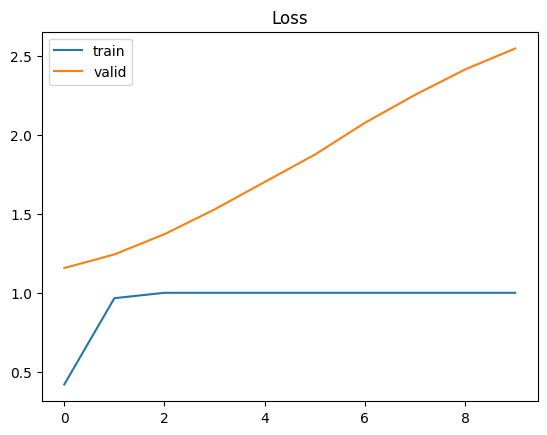

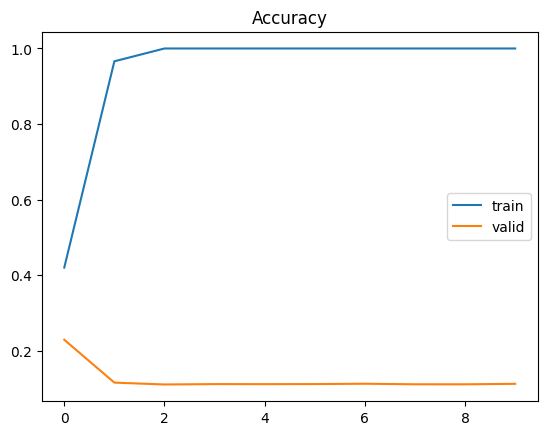

In [19]:
plot_history(resnet50_history)

### VGG19

In [20]:
torch.cuda.empty_cache()

In [21]:
vgg19_model, vgg_input_size = init_model(
    "vgg",
    num_classes=NUM_CLASSES,
    feature_extract=False,
    use_pretrained=True,
)

In [22]:
vgg19_model = vgg19_model.to(device)
vgg19_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [23]:
train_dataloader, test_dataloader = prepare_dataloaders(
    image_info_df,
    image_size=(vgg_input_size, vgg_input_size),
    test_size=0.8,
    device=device,
    labels=encoded_labels,
    shuffle_train=True,
    shuffle_test=True,
    batch_size_train=BATCH_SIZE,
    batch_size_test=BATCH_SIZE
)

100%|██████████| 3255/3255 [00:17<00:00, 188.55it/s]


In [24]:
optimizer = optim.Adam(vgg19_model.parameters(), lr=1e-5)
loss_function = torch.nn.CrossEntropyLoss().to(device)

vgg19_history = training(
    vgg19_model,
    train_dataloader,
    test_dataloader,
    optimizer,
    loss_function
)

=============== Epoch: 1 ===============
Train: loss=0.306, accuracy=0.947
Validation: loss=7.648, accuracy=0.113
Time elapsed: 17.89 s
=============== Epoch: 2 ===============
Train: loss=0.000, accuracy=1.000
Validation: loss=14.443, accuracy=0.112
Time elapsed: 14.37 s
=============== Epoch: 3 ===============
Train: loss=0.000, accuracy=1.000
Validation: loss=15.805, accuracy=0.112
Time elapsed: 15.04 s
=============== Epoch: 4 ===============
Train: loss=0.000, accuracy=1.000
Validation: loss=15.943, accuracy=0.113
Time elapsed: 17.79 s
=============== Epoch: 5 ===============
Train: loss=0.000, accuracy=1.000
Validation: loss=15.977, accuracy=0.112
Time elapsed: 15.21 s
=============== Epoch: 6 ===============
Train: loss=0.000, accuracy=1.000
Validation: loss=16.001, accuracy=0.114
Time elapsed: 19.06 s
=============== Epoch: 7 ===============
Train: loss=0.000, accuracy=1.000
Validation: loss=16.013, accuracy=0.112
Time elapsed: 22.90 s
=============== Epoch: 8 ===============
T

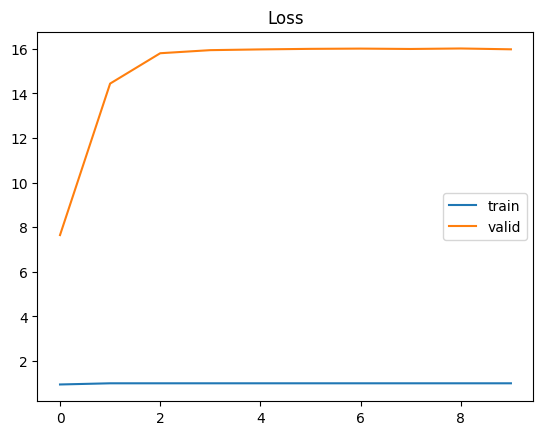

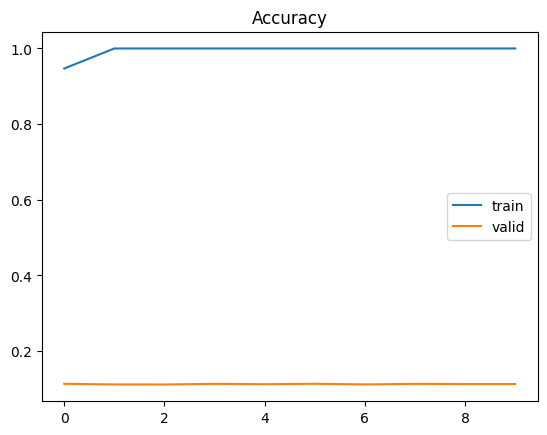

In [25]:
plot_history(vgg19_history)